<a href="https://colab.research.google.com/github/vedantdalvi7/Robustness-Evaluation-of-Neural-Network-based-image-processing-models/blob/main/Image_Segmentation_UNet_Cityscapes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import seaborn as sns
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from __future__ import print_function, absolute_import, division
from collections import namedtuple

In [3]:
print("tensorflow version: {}".format(tf.__version__))

tensorflow version: 2.12.0


In [4]:
!pip show keras

Name: keras
Version: 2.12.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /usr/local/lib/python3.9/dist-packages
Requires: 
Required-by: keras-vis, tensorflow


In [5]:
os.listdir('/content/gdrive/MyDrive/dataset')

['images_prepped_train',
 'annotations_prepped_train_greyscale',
 'corrupted_test_images',
 'clean_test_images',
 'annotations_test']

In [6]:
#Train samples
img_path = "/content/gdrive/MyDrive/dataset/images_prepped_train/"
annot_path = "/content/gdrive/MyDrive/dataset/annotations_prepped_train_greyscale/"
test_clean_path = "/content/gdrive/MyDrive/dataset/clean_test_images/lindau/"
test_corr_path = "/content/gdrive/MyDrive/dataset/corrupted_test_images/gaussian noise 5/"
test_annot_path = "/content/gdrive/MyDrive/dataset/annotations_test/annot_test/"

#Sort images
list_img = np.sort(next(os.walk(img_path), (None, None, []))[2])
list_annot = np.sort(next(os.walk(annot_path), (None, None, []))[2])
list_test_clean = np.sort(next(os.walk(test_clean_path), (None, None, []))[2])
list_test_corr = np.sort(next(os.walk(test_corr_path), (None, None, []))[2])
list_annot_test = np.sort(next(os.walk(test_annot_path), (None, None, []))[2])
#list_annot = encode_labels(list_annot)
#print(list_annot)
#print(list_img)
len(list_img), len(list_annot)
#len(test_clean_path), len(test_corr_path)

(365, 365)

In [7]:
len(list_test_clean), len(list_test_corr)


(59, 59)

In [8]:
len(list_annot_test)

59

In [9]:
# to make sure our annotation dataset has same name with our image
list_img[300], list_annot[300]

('strasbourg_000001_047619_leftImg8bit.png',
 'strasbourg_000001_047619_gtFine_labelIds.png')

In [10]:
import glob

train_images_dir = sorted(glob.glob(img_path+'/*.png'))
train_annotations_dir = sorted(glob.glob(annot_path+'/*.png'))
test_images_clean_dir = sorted(glob.glob(test_clean_path+'/*.png'))
test_images_corr_dir = sorted(glob.glob(test_corr_path+'/*.png'))
test_annotations_dir = sorted(glob.glob(test_annot_path+'/*.png'))

In [11]:
# convert to list of images
train_images = []
for img in train_images_dir:
  n = cv2.imread(img)
  train_images.append(n)

train_annotations = []
for img in train_annotations_dir:
  n = cv2.imread(img)
  train_annotations.append(n)   

test_images_clean = []
for img in test_images_clean_dir:
  n = cv2.imread(img)
  test_images_clean.append(n)

test_images_corr = []
for img in test_images_corr_dir:
  n = cv2.imread(img)
  test_images_corr.append(n)

test_annotations = []
for img in test_annotations_dir:
  n = cv2.imread(img)
  test_annotations.append(n)  

In [12]:
def get_colored_segmentation_image(seg, colors, n_classes):
  """ Return a colored segmented image """
  seg_img = np.zeros_like(seg)

  for c in range(n_classes):
    seg_img[:, :, 0] += ((seg[:, :, 0] == c)
                        * (colors[c][0])).astype('uint8')
    seg_img[:, :, 1] += ((seg[:, :, 0] == c)
                        * (colors[c][1])).astype('uint8')
    seg_img[:, :, 2] += ((seg[:, :, 0] == c)
                        * (colors[c][2])).astype('uint8')

  return seg_img

# initiate fix colors list
class_colors = [(128,0,0), (170,110,40), (128,128,0), (0,128,128),
                (0,0,128), (230,25,75), (245,130,48), (255,255,25),
                (210,245,60), (240,50,230), (128,128,128), (220,190,255),
                (255,215,180), (70,140,240), (0,130,200)]


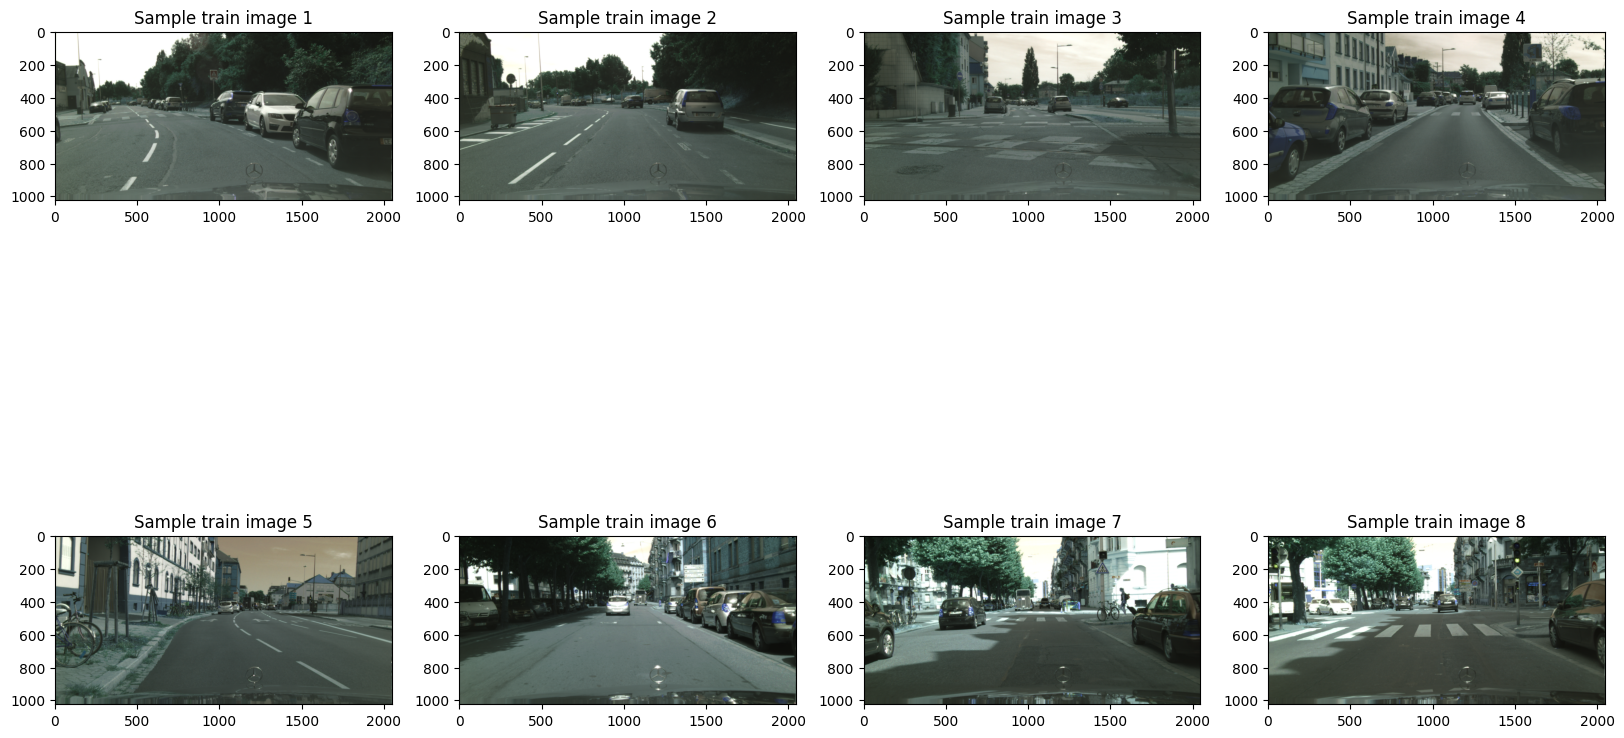

In [13]:
fig = plt.figure(figsize = (20,12))

for index in range(8):
  ax = fig.add_subplot(2,4,index+1)
  ax.set_title("Sample train image {}".format(index+1))
  ax.imshow(train_images[index], cmap='gray')

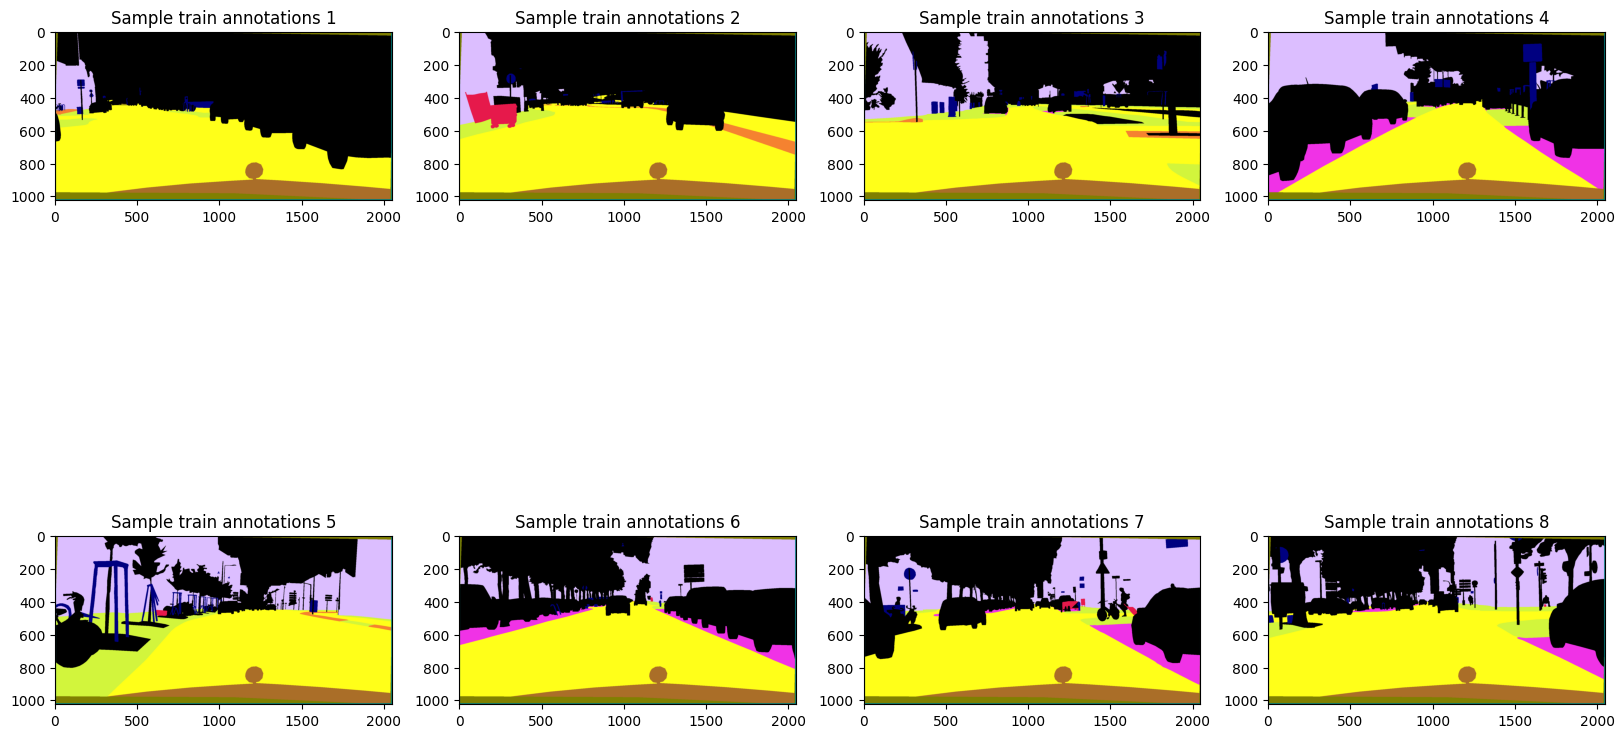

In [14]:
#Plot sample of train annotations
fig = plt.figure(figsize = (20,12))
mask_train = []

for index in range(8):
    #image = mpimg.imread(os.path.join(train_annotations_dir, os.listdir(train_annotations_dir)[index]))
    ax = fig.add_subplot(2,4,index+1)
    ax.set_title("Sample train annotations {}".format(index+1))
    masks = get_colored_segmentation_image(train_annotations[index],n_classes=12,colors=class_colors)
    mask_train.append(masks)
    ax.imshow(masks)

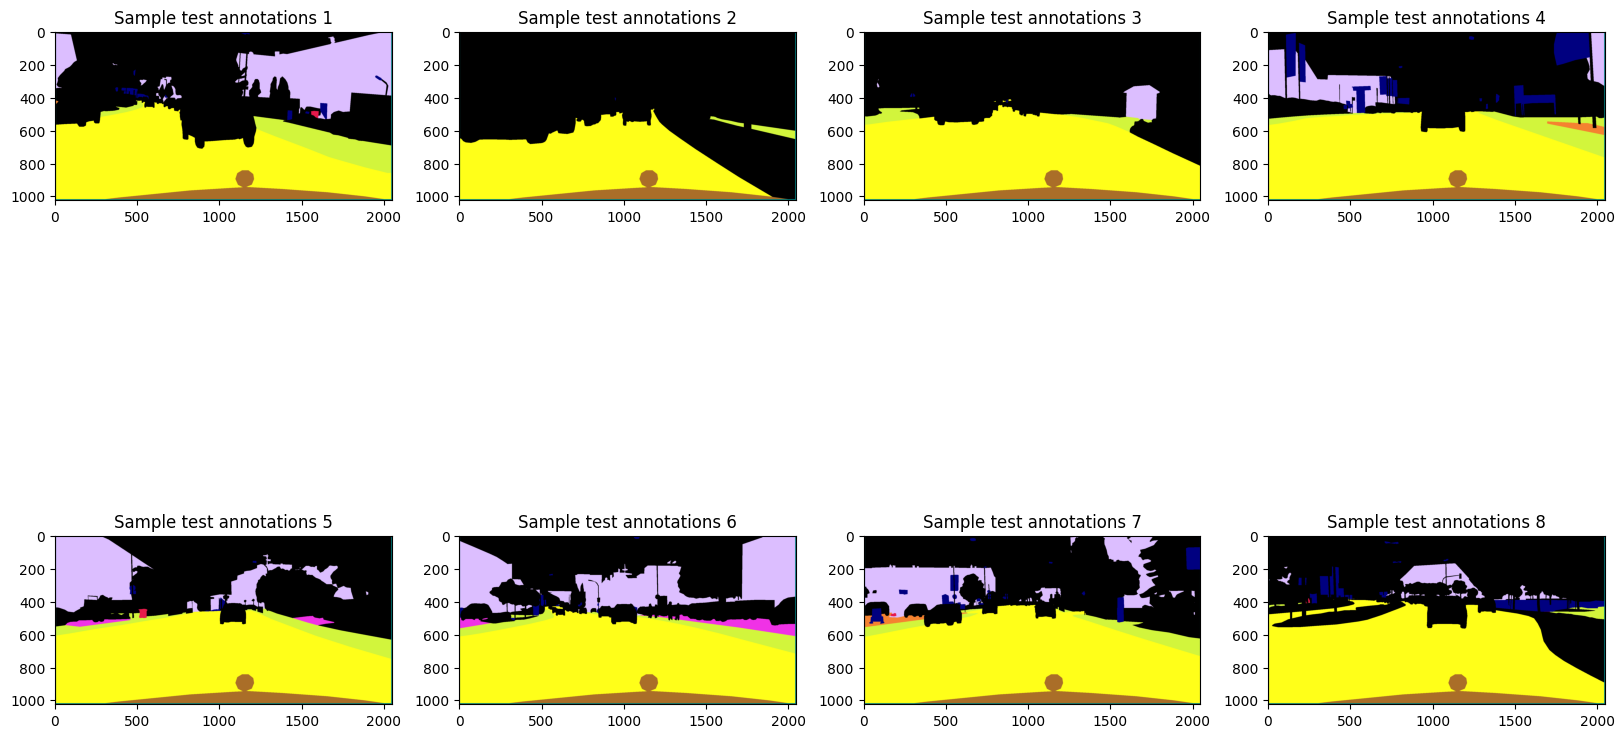

In [15]:
#Plot sample of test annotations
fig = plt.figure(figsize = (20,12))
mask_test = []

for index in range(8):
    #image = mpimg.imread(os.path.join(train_annotations_dir, os.listdir(train_annotations_dir)[index]))
    ax = fig.add_subplot(2,4,index+1)
    ax.set_title("Sample test annotations {}".format(index+1))
    masks = get_colored_segmentation_image(test_annotations[index],n_classes=12,colors=class_colors)
    mask_test.append(masks)
    ax.imshow(masks)

In [16]:
#Resize images to 128 x 128 
train_images = []
for img in train_images_dir:
  n = cv2.imread(img)
  n = cv2.resize(n, (128,128))
  train_images.append(n)  

train_annotations = []
for img in train_annotations_dir:
  n = cv2.imread(img, cv2.IMREAD_UNCHANGED) #reading 1 dimension only
  n = cv2.resize(n, (128,128))
  train_annotations.append(n)

test_images_clean = []
for img in test_images_clean_dir:
  n = cv2.imread(img)
  n = cv2.resize(n, (128,128))
  test_images_clean.append(n)  

test_images_corr = []
for img in test_images_corr_dir:
  n = cv2.imread(img)
  n = cv2.resize(n, (128,128))
  test_images_corr.append(n)  

test_annotations = []
for img in test_annotations_dir:
  n = cv2.imread(img, cv2.IMREAD_UNCHANGED) #reading 1 dimension only
  n = cv2.resize(n, (128,128))
  test_annotations.append(n)  

In [17]:
print("There are {} images in train images".format(len(os.listdir(img_path))))
print("\nThere are {} images in train annotations".format(len(os.listdir(annot_path))))

print("\nThere are {} images in test images clean".format(len(os.listdir(test_clean_path))))
print("\nThere are {} images in test images corr".format(len(os.listdir(test_corr_path))))
print("\nThere are {} images in test annotations".format(len(os.listdir(test_annot_path))))

There are 365 images in train images

There are 365 images in train annotations

There are 59 images in test images clean

There are 59 images in test images corr

There are 59 images in test annotations


In [18]:
print("shape of one sample image in train images dataset: {}".format(train_images[0].shape))
print("\nshape of one sample image in train annotations dataset: {}".format(train_annotations[0].shape))

print("\nshape of one sample image in test images clean dataset: {}".format(test_images_clean[0].shape))
print("\nshape of one sample image in test images corr dataset: {}".format(test_images_corr[0].shape))
print("\nshape of one sample image in test annotations dataset: {}".format(test_annotations[0].shape))

#print(train_annotations)

shape of one sample image in train images dataset: (128, 128, 3)

shape of one sample image in train annotations dataset: (128, 128)

shape of one sample image in test images clean dataset: (128, 128, 3)

shape of one sample image in test images corr dataset: (128, 128, 3)

shape of one sample image in test annotations dataset: (128, 128)


In [19]:
train_images = np.array(train_images)
train_annotations = np.array(train_annotations)

test_images_clean = np.array(test_images_clean)
test_images_corr = np.array(test_images_corr)

test_annotations = np.array(test_annotations)
#print(labels)

In [20]:
train_annotations = np.expand_dims(train_annotations, axis=-1)
test_annotations = np.expand_dims(test_annotations, axis=-1)

In [21]:
#x_train, x_test = train_images[:300], train_images[300:]
#y_train, y_test = train_annotations[:300], train_annotations[300:]

In [22]:
x_train = train_images
y_train = train_annotations

x_test_clean = test_images_clean
x_test_corr = test_images_corr

y_test = test_annotations

In [23]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test_clean = np.array(x_test_clean)
x_test_corr = np.array(x_test_corr)
y_test = np.array(y_test)

In [24]:
y_train = np.array(y_train).squeeze()
 #dimension removal

In [25]:
y_test = np.array(y_test).squeeze() 

In [26]:
print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))


x_train shape: (365, 128, 128, 3)
y_train shape: (365, 128, 128)
y_test shape: (59, 128, 128)


In [28]:
print("x_test_clean shape: {}".format(x_test_clean.shape))
print("x_test_corr shape: {}".format(x_test_corr.shape))

x_test_clean shape: (59, 128, 128, 3)
x_test_corr shape: (59, 128, 128, 3)


In [29]:
classes = np.unique(y_train)
num_class = len(classes)
print("classes in image: {} : \n {}".format(num_class, classes))

classes in image: 34 : 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]


In [30]:
label_train = tf.keras.utils.to_categorical(y_train, num_class)
label_test = tf.keras.utils.to_categorical(y_test, num_class)

#print(label_train)
#label_test

In [31]:
print("image shape: {}".format(x_train.shape))
print("label shape: {}".format(label_train.shape))
print("label test shape: {}".format(label_test.shape))     

image shape: (365, 128, 128, 3)
label shape: (365, 128, 128, 34)
label test shape: (59, 128, 128, 34)


In [32]:
y_train[0].shape

(128, 128)

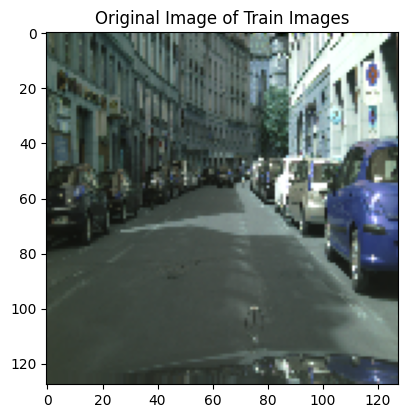

In [33]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.set_title("Original Image of Train Images")
ax1.imshow(x_train[50], cmap='gray')

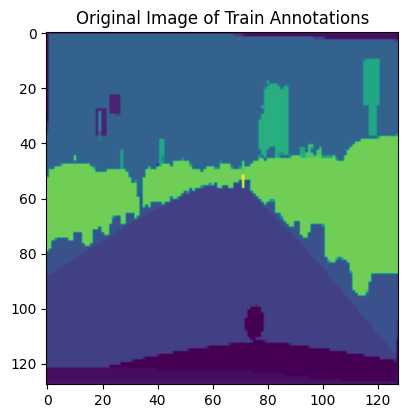

In [34]:
fig = plt.figure(figsize = (10,5))
ax2 = fig.add_subplot(1,2,1)
ax2.set_title("Original Image of Train Annotations")
ax2.imshow(y_train[50])     

In [35]:
height = x_train.shape[1]
width = x_train.shape[2]
channel = x_train.shape[3]     

In [36]:
inputs = tf.keras.Input((width, height, channel))

conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = concatenate([conv4,up6], axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

conv10 = Conv2D(34, 1, activation = 'softmax')(conv9)


model = tf.keras.Model(inputs, conv10)

model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [37]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') is not None and logs.get('val_accuracy') > 0.85:
      print("\nReached 85% validation accuracy so cancelling training!")
      self.model.stop_training = True
     

In [38]:
callbacks = myCallback()

history = model.fit(
    x_train,
    label_train,
    validation_data=(x_test_clean, label_test),
    epochs=25,
    batch_size=4,
    callbacks=[callbacks]
)
     

Epoch 1/25
 6/92 [>.............................] - ETA: 9s - loss: 5815.3696 - accuracy: 0.1445

92/92 [==============================] - 38s 165ms/step - loss: 387.1660 - accuracy: 0.3391 - val_loss: 2.3772 - val_accuracy: 0.4320
Epoch 2/25
92/92 [==============================] - 10s 112ms/step - loss: 1.7070 - accuracy: 0.5494 - val_loss: 2.2363 - val_accuracy: 0.4516
Epoch 3/25
92/92 [==============================] - 10s 111ms/step - loss: 1.3658 - accuracy: 0.6142 - val_loss: 2.1056 - val_accuracy: 0.5204
Epoch 4/25
92/92 [==============================] - 10s 113ms/step - loss: 1.2613 - accuracy: 0.6525 - val_loss: 2.4750 - val_accuracy: 0.5464
Epoch 5/25
92/92 [==============================] - 10s 114ms/step - loss: 1.2067 - accuracy: 0.6678 - val_loss: 2.4149 - val_accuracy: 0.5517
Epoch 6/25
92/92 [==============================] - 11s 117ms/step - loss: 1.1539 - accuracy: 0.6805 - val_loss: 2.4518 - val_accuracy: 0.5358
Epoch 7/25
92/92 [==============================] - 11s 118ms/step - loss: 1.1260 - accuracy: 0.6902 - val_loss: 3.2268 - val_accuracy: 0.5394
Epoch 8/

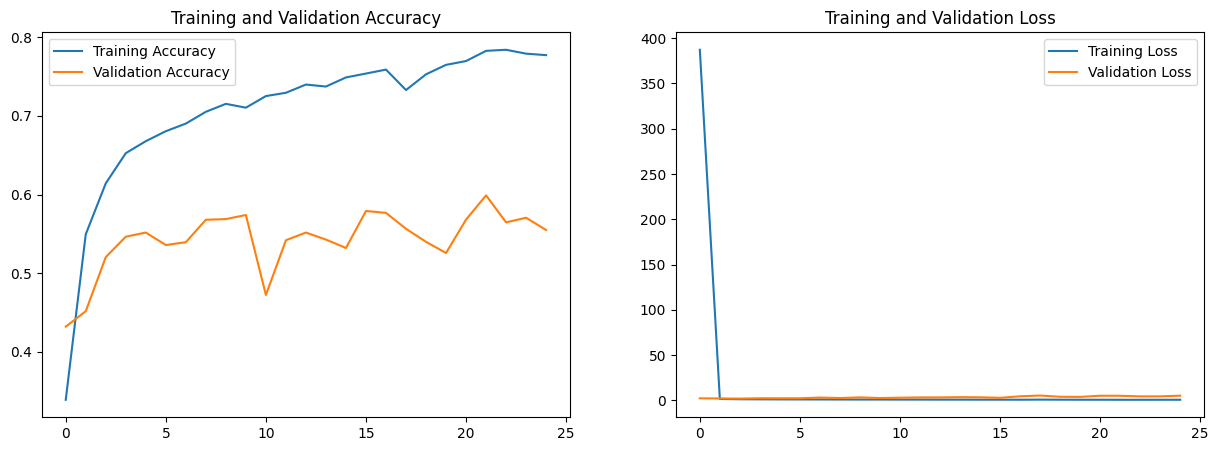

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.plot(epochs, acc, label='Training Accuracy')
ax1.plot(epochs, val_acc, label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.legend(loc=0)

ax2.plot(epochs, loss, label='Training Loss')
ax2.plot(epochs, val_loss, label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.legend(loc=0)
     

In [40]:
model.save('/content/gdrive/MyDrive/unet.h5')

In [41]:

load = tf.keras.models.load_model('/content/gdrive/MyDrive/unet.h5')
     

In [42]:
y_pred = load.predict(x_test_clean)
y_pred_argmax = np.argmax(y_pred, axis=3)
y_pred_argmax.shape

2/2 [==============================] - 11s 5s/step


(59, 128, 128)

In [43]:
metrics = load.evaluate(x_test_clean, y_pred)
print("{}: {}".format(load.metrics_names[0], metrics[0]))
print("{}: {}".format(load.metrics_names[1], metrics[1]))
     

2/2 [==============================] - 1s 169ms/step - loss: 1.0831 - accuracy: 1.0000
loss: 1.0831401348114014
accuracy: 1.0


In [47]:
from keras.metrics import MeanIoU

n_classes = 34
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


Mean IoU = 0.10878877


In [48]:
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)

In [49]:
val = 0
total = 0
res = []

for i in range (n_classes):
  val = values[i,i]
  sum1 = 0

  for j in range (n_classes):
    sum1 = values[i,j] + sum1
  sum2 = 0

  for x in range(n_classes):
    if x != i:
      sum2 = values[x, i] + sum2
    else:
      continue
  total = sum1 + sum2
  res.append(val/total)
  print("IoU class {}: {}".format(i,res[i]))

IoU class 0: 0.0
IoU class 1: 0.26364690575856997
IoU class 2: 0.0
IoU class 3: 0.993095285066088
IoU class 4: 0.00012627059789128102
IoU class 5: 0.0
IoU class 6: 1.0138286224096679e-05
IoU class 7: 0.5443199586401695
IoU class 8: 0.15172568145999832
IoU class 9: 0.0
IoU class 10: 0.0
IoU class 11: 0.49281521088171903
IoU class 12: 0.0001661221551580929
IoU class 13: 0.00787866850502265
IoU class 14: 0.0
IoU class 15: 0.0
IoU class 16: 0.0
IoU class 17: 0.025490816972767574
IoU class 18: 0.0
IoU class 19: 0.0
IoU class 20: 0.0
IoU class 21: 0.5861308448007444
IoU class 22: 0.0006881260035170885
IoU class 23: 0.3589225589225589
IoU class 24: 0.009480919649205973
IoU class 25: 0.0
IoU class 26: 0.26091954022988506
IoU class 27: 0.0
IoU class 28: 0.0
IoU class 29: 0.0
IoU class 30: 0.0
IoU class 31: 0.0
IoU class 32: 0.0
IoU class 33: 0.003401360544217687


<BarContainer object of 34 artists>

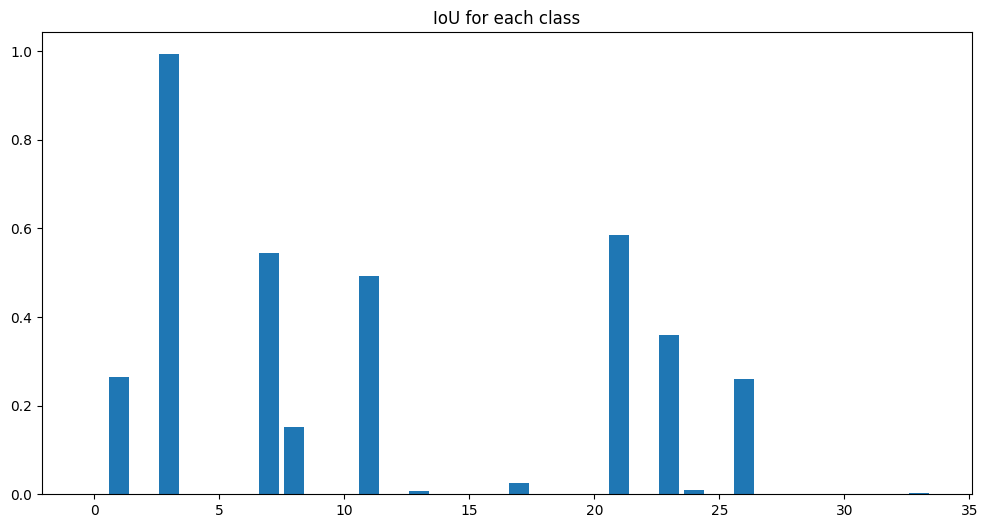

In [50]:
# Plot IoU

index = []
for i in range (len(res)):
  index.append(i)
plt.figure(figsize=(12,6))
plt.title("IoU for each class")
plt.bar(index, res)

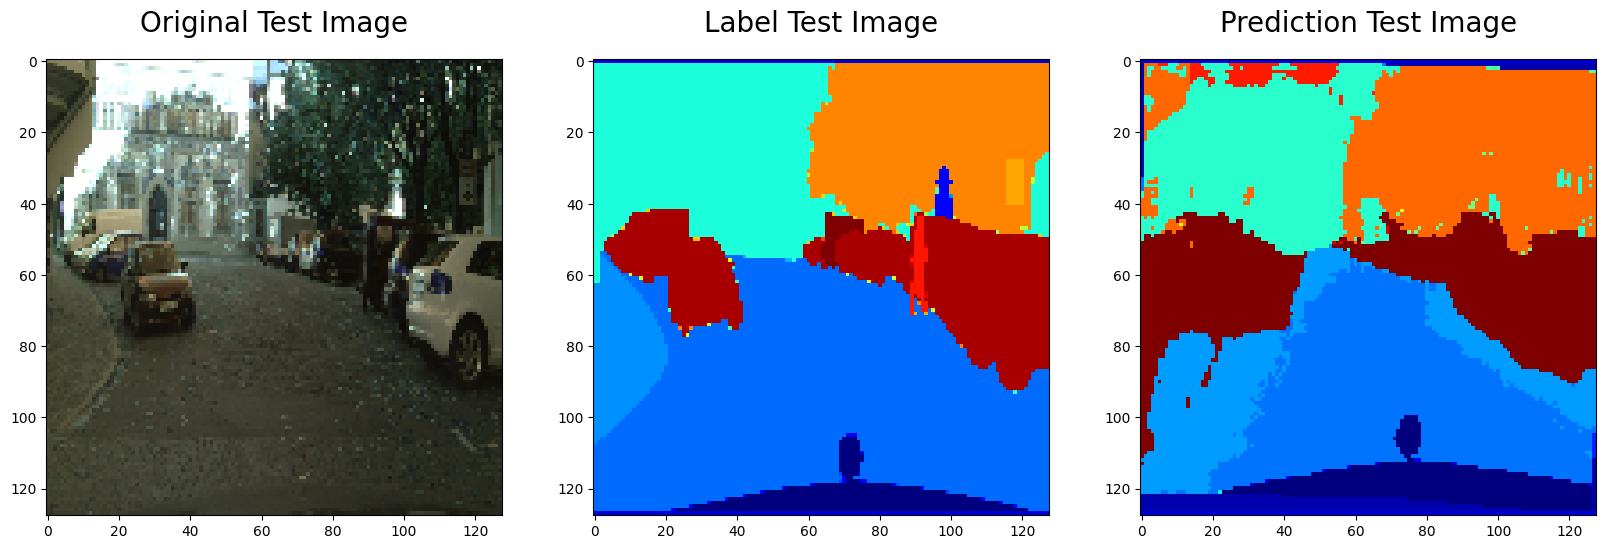

In [51]:
num = random.randint(0,len(x_test_clean))

plt.figure(figsize=(20,20))

plt.subplot(231)
plt.title('Original Test Image', fontsize=20, pad=20)
plt.imshow(x_test_clean[num])

plt.subplot(232)
plt.title('Label Test Image', fontsize=20, pad=20)
plt.imshow(y_test[num].squeeze(), cmap='jet')

plt.subplot(233)
plt.title('Prediction Test Image', fontsize=20, pad=20)
plt.imshow(y_pred_argmax[num], cmap='jet')

plt.show()

In [52]:
y_pred2 = load.predict(x_test_corr)
y_pred2_argmax = np.argmax(y_pred2, axis=3)
y_pred2_argmax.shape

2/2 [==============================] - 0s 195ms/step


(59, 128, 128)

In [53]:

metrics = load.evaluate(x_test_corr, y_pred2)
print("{}: {}".format(load.metrics_names[0], metrics[0]))
print("{}: {}".format(load.metrics_names[1], metrics[1]))

2/2 [==============================] - 0s 176ms/step - loss: 1.5470 - accuracy: 1.0000
loss: 1.5470165014266968
accuracy: 1.0


In [55]:
from keras.metrics import MeanIoU

n_classes = 34
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:], y_pred2_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


Mean IoU = 0.066574164


In [56]:
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)

In [57]:
val = 0
total = 0
res = []

for i in range (n_classes):
  val = values[i,i]
  sum1 = 0

  for j in range (n_classes):
    sum1 = values[i,j] + sum1
  sum2 = 0

  for x in range(n_classes):
    if x != i:
      sum2 = values[x, i] + sum2
    else:
      continue
  total = sum1 + sum2
  res.append(val/total)
  print("IoU class {}: {}".format(i,res[i]))

IoU class 0: 0.0
IoU class 1: 0.25816011353201435
IoU class 2: 0.0
IoU class 3: 0.9875641531780498
IoU class 4: 0.0036050376890303854
IoU class 5: 0.0006600660066006601
IoU class 6: 0.0004452494915048421
IoU class 7: 0.24653776098508226
IoU class 8: 0.043900393878879486
IoU class 9: 0.0002039983680130559
IoU class 10: 0.0
IoU class 11: 0.31100309243758445
IoU class 12: 0.0009674298613350532
IoU class 13: 0.007533552798176754
IoU class 14: 0.0
IoU class 15: 0.0
IoU class 16: 0.0
IoU class 17: 0.004619401486242217
IoU class 18: 0.0
IoU class 19: 0.0
IoU class 20: 0.001095290251916758
IoU class 21: 0.28544567000763493
IoU class 22: 0.0009543385699603582
IoU class 23: 0.010020239556720528
IoU class 24: 0.003654616705561182
IoU class 25: 0.0
IoU class 26: 0.09407314702818349
IoU class 27: 0.0
IoU class 28: 0.0
IoU class 29: 0.0
IoU class 30: 0.0
IoU class 31: 0.0
IoU class 32: 0.0
IoU class 33: 0.0030781451692979845


<BarContainer object of 34 artists>

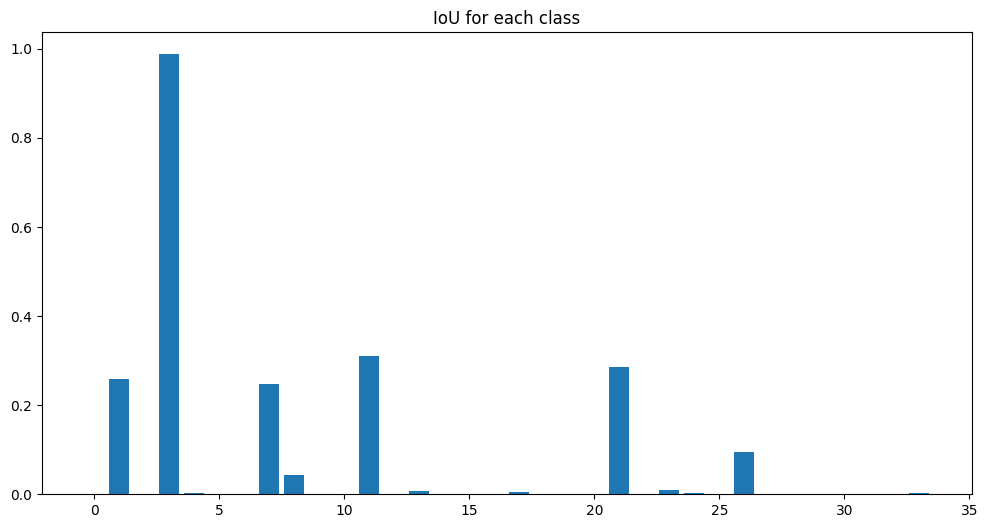

In [58]:
# Plot IoU

index = []
for i in range (len(res)):
  index.append(i)
plt.figure(figsize=(12,6))
plt.title("IoU for each class")
plt.bar(index, res)

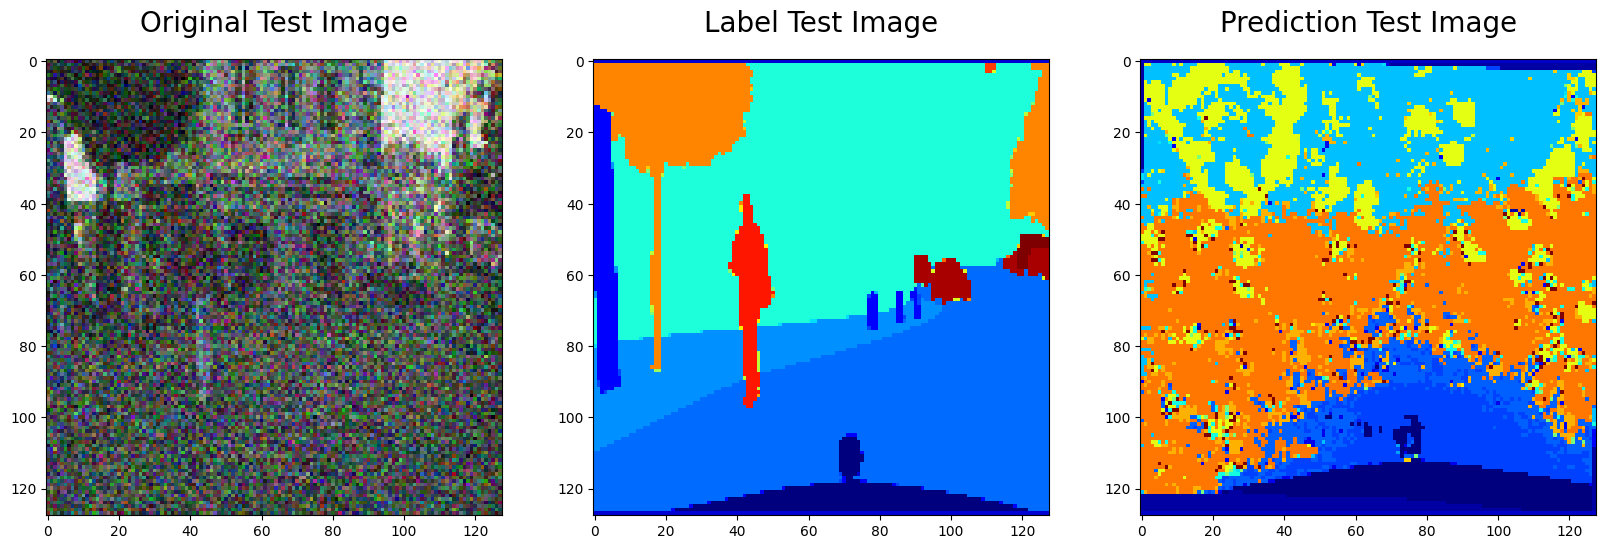

In [59]:
num = random.randint(0,len(x_test_corr))

plt.figure(figsize=(20,20))

plt.subplot(231)
plt.title('Original Test Image', fontsize=20, pad=20)
plt.imshow(x_test_corr[num])

plt.subplot(232)
plt.title('Label Test Image', fontsize=20, pad=20)
plt.imshow(y_test[num].squeeze(), cmap='jet')

plt.subplot(233)
plt.title('Prediction Test Image', fontsize=20, pad=20)
plt.imshow(y_pred2_argmax[num], cmap='jet')

plt.show()